# Classification Project: Working on Heart rate of Patients!
The main goal is to predict the chance of heart attack of a patient according to the heart attack database!

**Step 1: Importing the required libraries**

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy 
from sklearn.preprocessing import StandardScaler , OneHotEncoder , MinMaxScaler , OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score , recall_score , f1_score , accuracy_score
from sklearn.model_selection import cross_val_predict , GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report , confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
import itertools    
from sklearn.feature_selection import SelectKBest , f_regression 

import warnings
warnings.filterwarnings("ignore")

**Step 2: Reading the Database and get more informations**

In [168]:
database = pd.read_csv('heart.csv')
print(database.head())
# This is to detect the missing values in the database
print(database.isnull().sum())

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  
age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


In [169]:
# Getting the information about the data distribution in the database
for col in database[["sex" , "cp" , "fbs" ,"restecg" , "exng" ,"output" ,"thall" , "caa" , "slp"  , "output"]]:
    print(database[col].value_counts()) 
    print("---------------------------")

sex
1    207
0     96
Name: count, dtype: int64
---------------------------
cp
0    143
2     87
1     50
3     23
Name: count, dtype: int64
---------------------------
fbs
0    258
1     45
Name: count, dtype: int64
---------------------------
restecg
1    152
0    147
2      4
Name: count, dtype: int64
---------------------------
exng
0    204
1     99
Name: count, dtype: int64
---------------------------
output
1    165
0    138
Name: count, dtype: int64
---------------------------
thall
2    166
3    117
1     18
0      2
Name: count, dtype: int64
---------------------------
caa
0    175
1     65
2     38
3     20
4      5
Name: count, dtype: int64
---------------------------
slp
2    142
1    140
0     21
Name: count, dtype: int64
---------------------------
output
1    165
0    138
Name: count, dtype: int64
---------------------------


**Step3: Visualization of data**

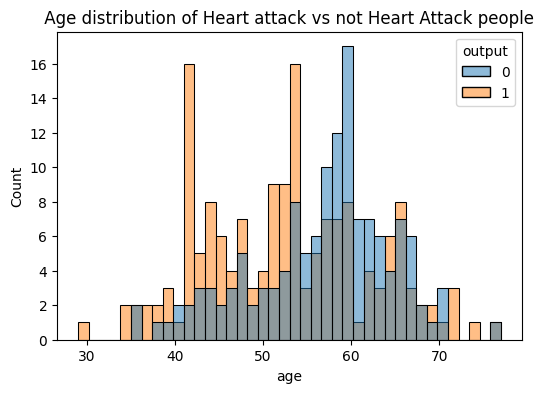

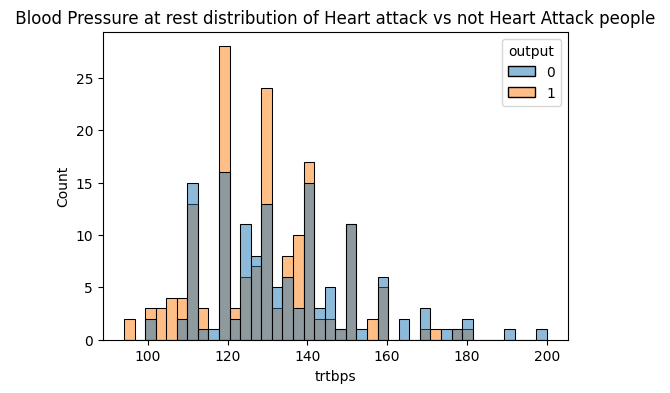

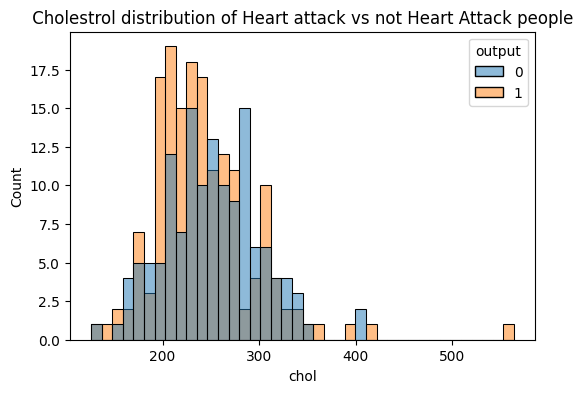

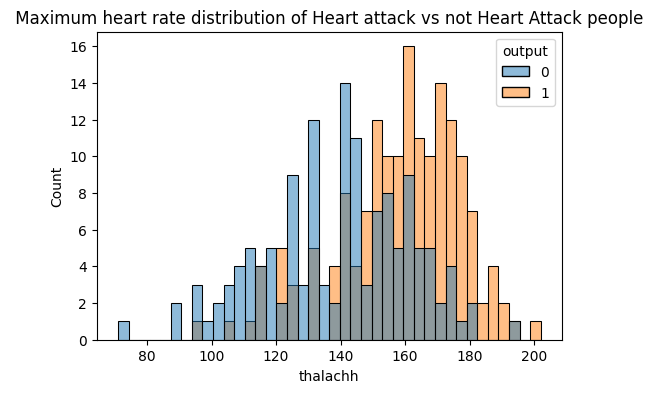

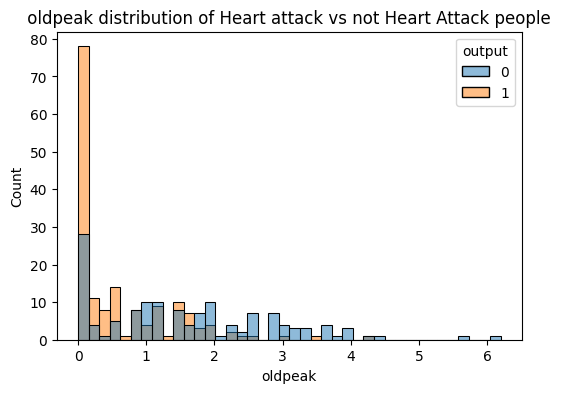

<Figure size 1000x800 with 0 Axes>

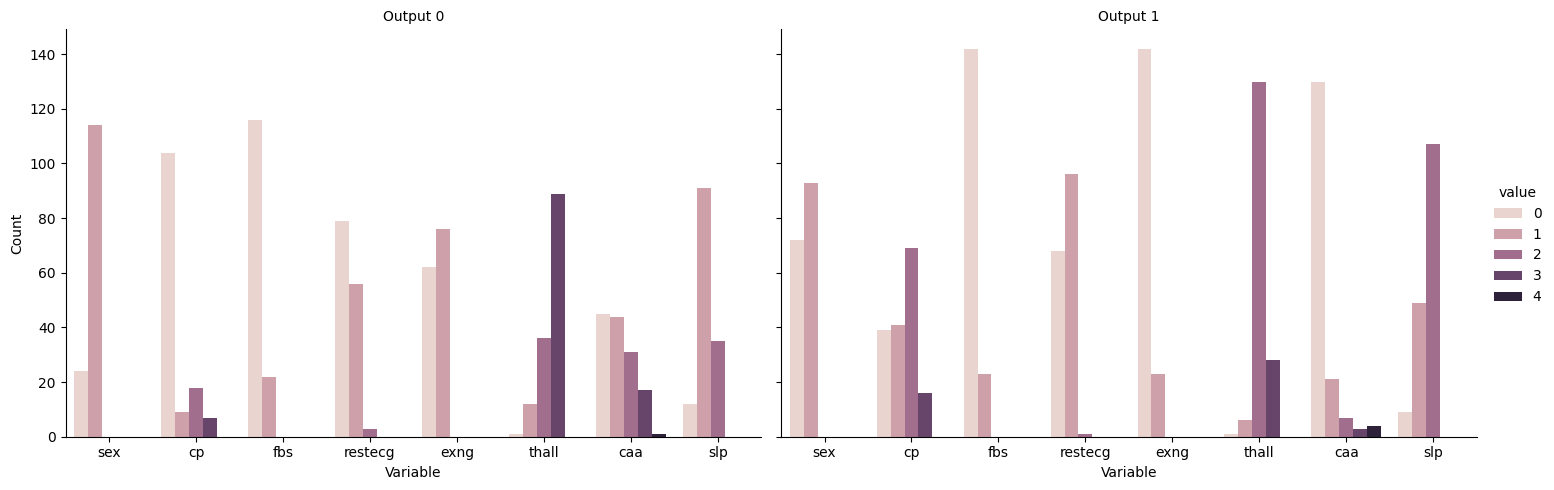

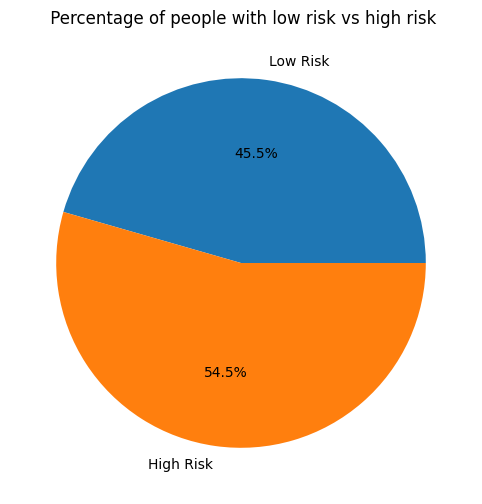

<Axes: >

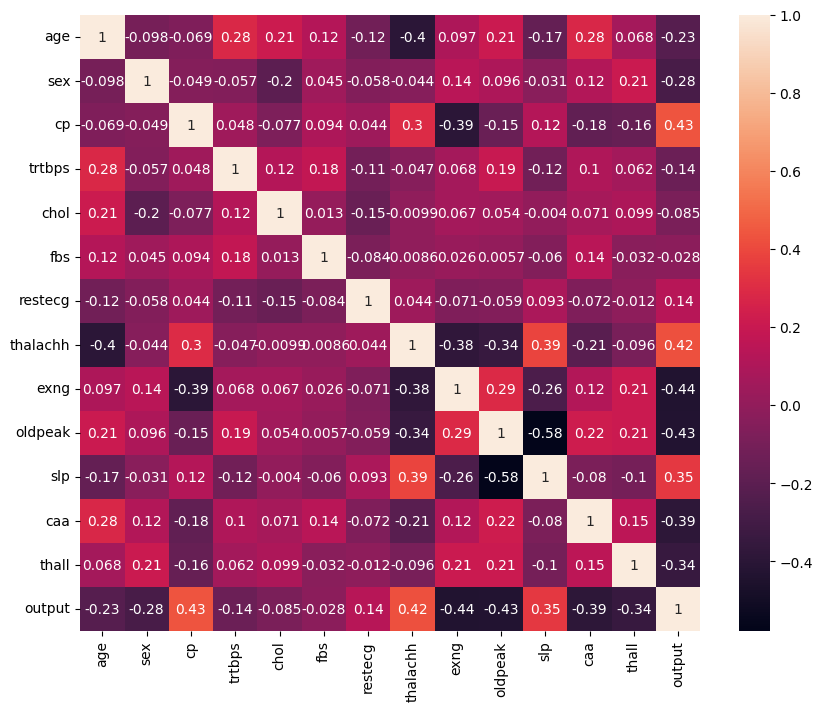

In [170]:
Dictionary={"age":"Age" , "trtbps":"Blood Pressure at rest" , "chol":"Cholestrol", "thalachh":"Maximum heart rate" , "oldpeak":"oldpeak"}
for col in database[["age" ,"trtbps" ,  "chol" , "thalachh" , "oldpeak"]]:
    plt.figure(figsize=(6 , 4))
    sns.histplot(x=col, data=database , bins=40  , hue="output")
    plt.title(f" {Dictionary[col]} distribution of Heart attack vs not Heart Attack people ")
    plt.show()
    

# This is to check the correlation between the features
cols = ["sex", "cp", "fbs", "restecg", "exng", "thall", "caa", "slp" ]
plt.figure(figsize=(10 , 8))
df_long = pd.melt(database, id_vars=["output"], value_vars=cols)
diagram = sns.catplot( x="variable", hue="value", col="output",data=df_long, kind="count",aspect=1.5)
diagram.set_axis_labels("Variable", "Count")
diagram.set_titles("Output {col_name}")
plt.show()


# Pie Chart for the output
plt.figure(figsize=(8 , 6))
labels=["Low Risk" , "High Risk"]
sizes=[database.output.value_counts()[0] ,database.output.value_counts()[1]]
plt.pie(sizes, labels=labels , autopct='%1.1f%%')
plt.title(" Percentage of people with low risk vs high risk")
plt.axis('off')
plt.show()


# Make a heatmap to check the correlation between the features
plt.figure(figsize=(10 , 8))
sns.heatmap(database.corr() , annot=True)

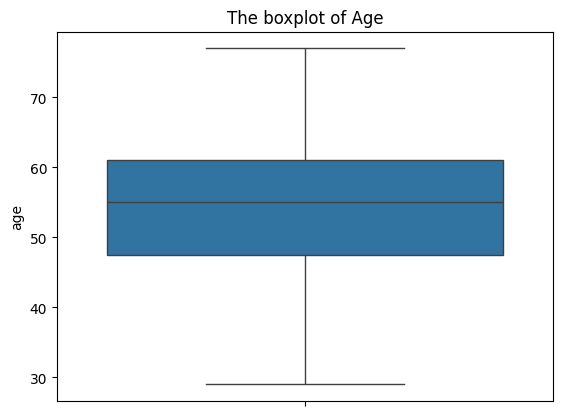

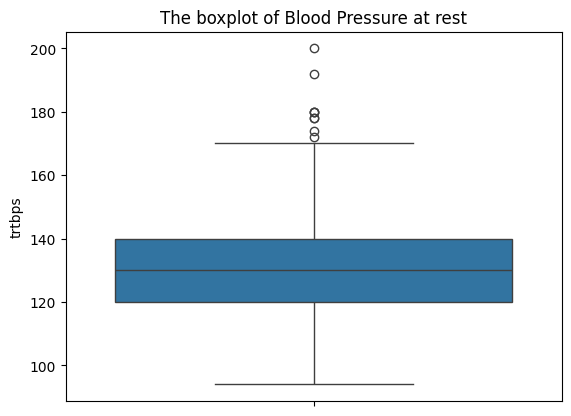

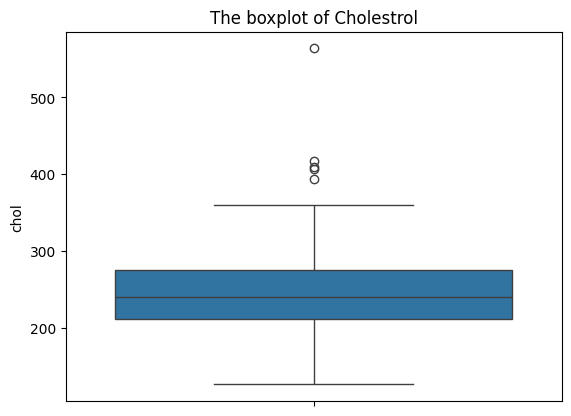

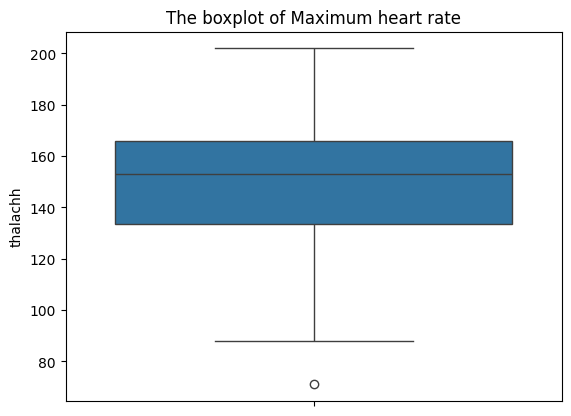

In [171]:
# Boxplot for the features
Dictionary={"age":"Age" , "trtbps":"Blood Pressure at rest" , "chol":"Cholestrol", "thalachh":"Maximum heart rate"}
for col in database[["age" , "trtbps" ,  "chol" , "thalachh"]]:
    sns.boxplot(y=col , data=database)
    plt.xlabel={col}
    plt.title(f"The boxplot of {Dictionary[col]}")
    plt.show()

**PreProcessing: Detect Outlier Data**

In [172]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

database = remove_outliers(database, ["age", "trtbps", "chol", "thalachh", "oldpeak"])

**Step4: Split data into train and test**

In [173]:
# Assign target and features
y = database["output"]
x = database.drop("output", axis=1)

# Select top 9 features
selector = SelectKBest(score_func=f_regression, k=9)
x_selected = selector.fit_transform(x, y)

# Get indices of top 7 features
selected_indices = np.argsort(selector.scores_)[::-1][:7]
selected_features = x.columns[selected_indices]

# Split the data into training and testing sets
x = x[selected_features]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

# Normalizing the data
num_features = ["thalachh", "oldpeak"]
cat_features = ["cp", "exng", "caa", "slp", "thall"]

full_pipeline = ColumnTransformer([
    ("num", MinMaxScaler(), num_features),
    ("cat", OneHotEncoder(), cat_features),
])

x_train_prepared = full_pipeline.fit_transform(x_train)
x_test_prepared = full_pipeline.transform(x_test)

**Step5: Select a convinient model**

In [174]:
sample_data=x_train.iloc[:5]
sample_label=y_train[:5]
sample_data_pre=full_pipeline.transform(sample_data)

# According to Jadi's comment, I borrowed the following code from his lecture :)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

In [175]:
def sample_data(model):
    print ("prediction :" ,  model.predict(sample_data_pre))
    print  ("labels:" ,  list(sample_label))

def gridsearchcv(param_grid , model):
    
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search=grid.fit(x_train_prepared, y_train)
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)

**Optimization Model Parameters:**

In [176]:
models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}

param_grids = {
    "KNN": {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    "DecisionTree": {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "LogisticRegression": {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    },
    "SVM": {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    }
}

best_models = {}
for model_name in models:
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(x_train_prepared, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best Hyperparameters for {model_name}: {grid_search.best_params_}")

# Step 6: Evaluate the best models on the test set
for model_name in best_models:
    y_pred = best_models[model_name].predict(x_test_prepared)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{model_name} Test Set Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Best Hyperparameters for KNN: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Best Hyperparameters for DecisionTree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Hyperparameters for LogisticRegression: {'C': 0.1, 'solver': 'lbfgs'}
Best Hyperparameters for SVM: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

KNN Test Set Accuracy: 0.8070175438596491
Confusion Matrix:
[[12  5]
 [ 6 34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        17
           1       0.87      0.85      0.86        40

    accuracy                           0.81        57
   macro avg       0.77      0.78      0.77        57
weighted avg       0.81      0.81      0.81        57


DecisionTree Test Set Accuracy: 0.6842105263157895
Confusion Matrix:
[[12  5]
 [13 27]]
Classification Report:
              precision    recall  f1-score   support

    

**Using KNN Method**

Precision score: 0.8412698412698413
Recall score: 0.8907563025210085
fscore score: 0.8653061224489796
accuracy score: 0.8546255506607929
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Best Accuracy: 0.85487922705314
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       108
           1       0.84      0.89      0.87       119

    accuracy                           0.85       227
   macro avg       0.86      0.85      0.85       227
weighted avg       0.86      0.85      0.85       227

Confusion matrix, without normalization
[[ 88  20]
 [ 13 106]]


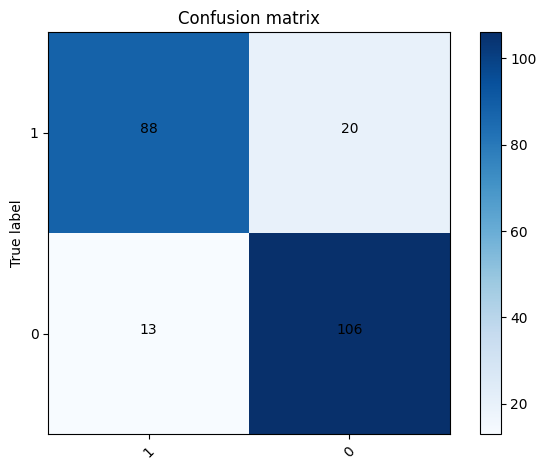

In [177]:
knn= KNeighborsClassifier(metric= 'euclidean', n_neighbors= 11, weights='uniform', algorithm='ball_tree')
knn.fit(x_train_prepared,y_train)
knn_pred = cross_val_predict(knn, x_train_prepared, y_train, cv=5)
precision = precision_score(y_train, knn_pred)
recall = recall_score(y_train, knn_pred)
fscore=f1_score(y_train ,knn_pred )
accuracy=accuracy_score(y_train ,knn_pred)
print(f"Precision score: {precision}")
print(f"Recall score: {recall}")
print(f"fscore score: {fscore}")
print(f"accuracy score: {accuracy}")

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9], 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan'] 
}
gridsearchcv(param_grid_knn , KNeighborsClassifier() )

# Plotting the confusion matrix
cm=confusion_matrix(y_train, knn_pred)
np.set_printoptions(precision=2)
print (classification_report(y_train, knn_pred))
plt.figure()
plot_confusion_matrix(cm, classes=['1','0'],normalize= False,  title='Confusion matrix')



**Using Decision Tree Method**

prediction : [0 1 1 0 0]
labels: [0, 1, 1, 0, 0]
Precision score: 0.8446601941747572
Recall score: 0.7310924369747899
fscore score: 0.7837837837837838
accuracy score: 0.788546255506608
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'random_state': None, 'splitter': 'random'}
Best Accuracy: 0.8504347826086956
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       108
           1       0.84      0.73      0.78       119

    accuracy                           0.79       227
   macro avg       0.79      0.79      0.79       227
weighted avg       0.80      0.79      0.79       227

Confusion matrix, without normalization
[[92 16]
 [32 87]]


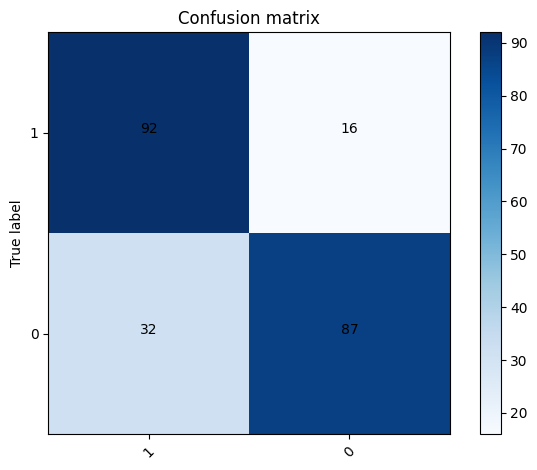

In [178]:
tree= DecisionTreeClassifier(criterion= 'entropy', max_depth =10, min_samples_leaf= 4,min_samples_split=5)

tree.fit(x_train_prepared,y_train)
sample_data(tree)

tree_pred = cross_val_predict(tree, x_train_prepared, y_train, cv=5)
precision = precision_score(y_train, tree_pred)
recall = recall_score(y_train, tree_pred)
fscore=f1_score(y_train ,tree_pred )
accuracy=accuracy_score(y_train ,tree_pred)
print(f"Precision score: {precision}")
print(f"Recall score: {recall}")
print(f"fscore score: {fscore}")
print(f"accuracy score: {accuracy}")

param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [None, 42]  
}
gridsearchcv(param_grid_tree , DecisionTreeClassifier())

cm=confusion_matrix(y_train, tree_pred)
np.set_printoptions(precision=2)
print (classification_report(y_train, tree_pred))
plt.figure()
plot_confusion_matrix(cm, classes=['1','0'],normalize= False,  title='Confusion matrix')

**Using Logistic Regression Method**

prediction : [0 1 1 0 1]
labels: [0, 1, 1, 0, 0]
Precision score: 0.84251968503937
Recall score: 0.8991596638655462
fscore score: 0.8699186991869918
accuracy score: 0.8590308370044053
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Best Accuracy: 0.8722705314009662
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       108
           1       0.84      0.90      0.87       119

    accuracy                           0.86       227
   macro avg       0.86      0.86      0.86       227
weighted avg       0.86      0.86      0.86       227

Confusion matrix, without normalization
[[ 88  20]
 [ 12 107]]


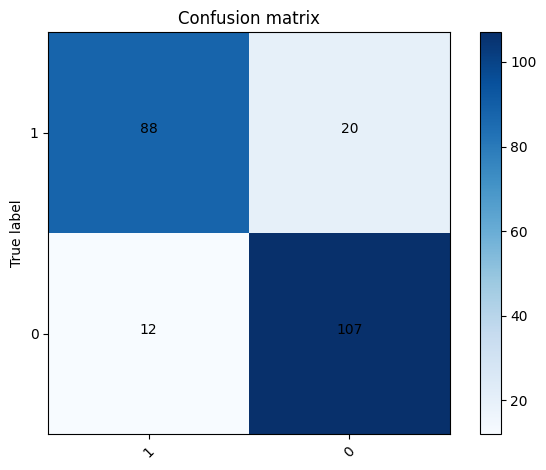

In [179]:
lr= LogisticRegression(C= 0.1, solver='lbfgs')
lr.fit(x_train_prepared,y_train)
sample_data(lr)

lr_pred = cross_val_predict(lr, x_train_prepared, y_train, cv=5)
precision = precision_score(y_train, lr_pred)
recall = recall_score(y_train, lr_pred)
fscore=f1_score(y_train ,lr_pred )
accuracy=accuracy_score(y_train ,lr_pred)
print(f"Precision score: {precision}")
print(f"Recall score: {recall}")
print(f"fscore score: {fscore}")
print(f"accuracy score: {accuracy}")

param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100] 
}
gridsearchcv(param_grid_lr , LogisticRegression())

cm=confusion_matrix(y_train, lr_pred)
np.set_printoptions(precision=2)
print (classification_report(y_train, lr_pred))
plt.figure()
plot_confusion_matrix(cm, classes=['1','0'],normalize= False,  title='Confusion matrix')

**Using SVC Method**

prediction : [0 1 1 0 1]
labels: [0, 1, 1, 0, 0]
Precision score: 0.8396946564885496
Recall score: 0.9243697478991597
fscore score: 0.88
accuracy score: 0.8678414096916299
Best Hyperparameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Accuracy: 0.8635748792270531
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       108
           1       0.84      0.90      0.87       119

    accuracy                           0.86       227
   macro avg       0.86      0.86      0.86       227
weighted avg       0.86      0.86      0.86       227

Confusion matrix, without normalization
[[ 88  20]
 [ 12 107]]


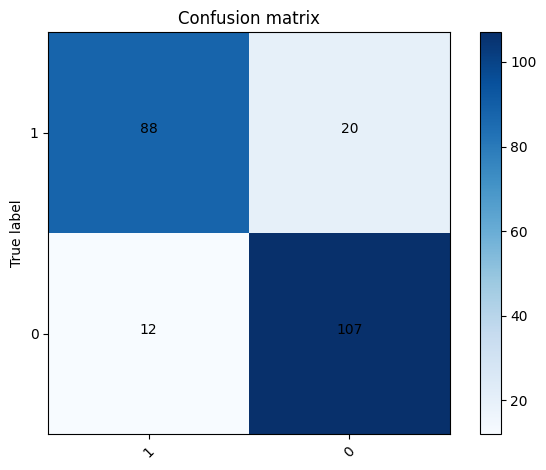

In [180]:
svm= SVC(C= 0.1, gamma= 'auto', kernel='rbf')
svm.fit(x_train_prepared,y_train)
sample_data(svm)

svm_pred = cross_val_predict(svm, x_train_prepared, y_train, cv=5)
precision = precision_score(y_train, svm_pred)
recall = recall_score(y_train, svm_pred)
fscore=f1_score(y_train ,svm_pred )
accuracy=accuracy_score(y_train ,svm_pred)
print(f"Precision score: {precision}")
print(f"Recall score: {recall}")
print(f"fscore score: {fscore}")
print(f"accuracy score: {accuracy}")

param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],}  
gridsearchcv(param_grid_svm , SVC())

cm=confusion_matrix(y_train, lr_pred)
np.set_printoptions(precision=2)
print (classification_report(y_train, lr_pred))
plt.figure()
plot_confusion_matrix(cm, classes=['1','0'],normalize= False,  title='Confusion matrix')

**Step6: Model Evaluation**

Logistic Regression

In [181]:
x_test_prepared= full_pipeline.transform(x_test)
x_test_predict=lr.predict(x_test_prepared)
print(f"Precision_Score:{precision_score(y_test , x_test_predict)}")
print(f"Recall_Score:{recall_score(y_test , x_test_predict)}")
print(f"Accuracy:{accuracy_score(y_test , x_test_predict)}")


Precision_Score:0.8717948717948718
Recall_Score:0.85
Accuracy:0.8070175438596491


SVM

In [183]:
x_test_prepared= full_pipeline.transform(x_test)
x_test_predict=svm.predict(x_test_prepared)
print(f"Precision_Score:{precision_score(y_test , x_test_predict)}")
print(f"Recall_Score:{recall_score(y_test , x_test_predict)}")
print(f"Accuracy:{accuracy_score(y_test , x_test_predict)}")

Precision_Score:0.8536585365853658
Recall_Score:0.875
Accuracy:0.8070175438596491
